In [2]:
from defense import *
from utils import *
import inceptionv3
import tqdm
import time

In [3]:
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=config)

In [4]:
# the seleted data from the imagenet validation set
cleandata = np.load("./data/clean100data.npy")
cleanlabel = np.load("./data/clean100label.npy")

orig = load_image('cat.jpg')
CORRECT_ori = 282 # tiger cat
TARGET_ori = 924 # guacamole 

In [5]:
TARGET = 999
sampleindex = 2

In [7]:
x = tf.placeholder(tf.float32, (299, 299, 3))
x_expanded = tf.expand_dims(x, axis=0)
logits, preds = inceptionv3.model(sess, x_expanded)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot(TARGET, 1000))
grad, = tf.gradients(loss,x)


probs = tf.nn.softmax(logits)
classify = make_classify(sess, x, probs)

INFO:tensorflow:Scale of 0 disables regularizer.


# Using a strong sample to demonstrate the defense

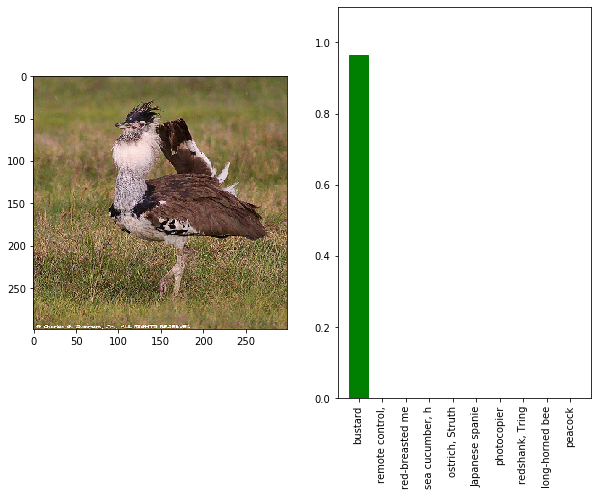

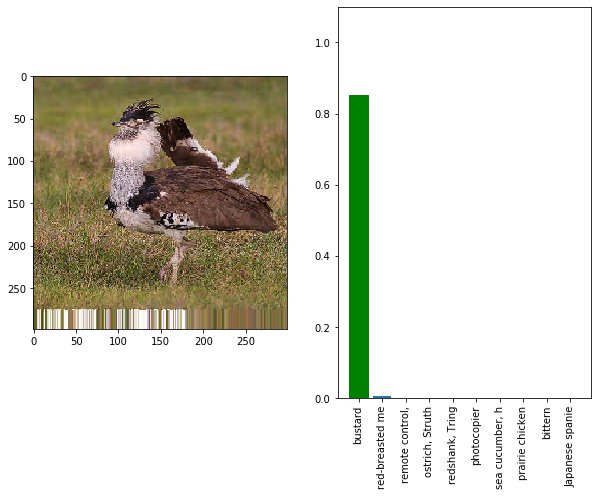

In [8]:
# demo based on a strong sample
# plot the original img and the defended version
classify(cleandata[sampleindex],correct_class=cleanlabel[sampleindex],target_class=TARGET)
classify(defend_GD(defend_FD_sig(cleandata[sampleindex]),0.25),correct_class=cleanlabel[sampleindex],target_class=TARGET)

In [9]:
#将防御机制导入进session以进行变换和求解
x_single = tf.placeholder(tf.float32, (299, 299, 3))
TARGET = 999

In [10]:
ENSEMBLE_SIZE = 30# larger sample size -> better gradient estimate

In [11]:
ensemble_xs = tf.stack([tftensorGD(x_single) for _ in range(ENSEMBLE_SIZE)], axis=0)

ensemble_logits, ensemble_preds = inceptionv3.model(sess, ensemble_xs)
ensemble_labels = tf.tile(tf.expand_dims(tf.one_hot(TARGET, 1000), axis=0), (ensemble_logits.shape[0], 1))
ensemble_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=ensemble_logits, labels=ensemble_labels))
ensemble_grad, = tf.gradients(ensemble_loss, x_single)
ensemble_probs = tf.nn.softmax(ensemble_logits)

INFO:tensorflow:Scale of 0 disables regularizer.


In [12]:
# BPDA + EOT
LR = 0.1

newadv = np.copy(cleandata[sampleindex])

for i in range(50):
    gradadv = defend_FD_sig(newadv)
    g, p, probs= sess.run([ensemble_grad, ensemble_preds,ensemble_probs], {x_single: gradadv})
    counts = np.bincount(p)
    p_label = np.argmax(counts)
    if i % 5 == 0:
        print('step %d, preds=%s' % (i, p_label))
    if p_label == TARGET:
        print('takes %d steps to conquer' % (i))
        break
    newadv -= LR * g
    # project
    newadv = np.clip(newadv, 0, 1)

step 0, preds=138
step 5, preds=138
step 10, preds=138
step 15, preds=138
step 20, preds=138
step 25, preds=138
step 30, preds=138
step 35, preds=138
step 40, preds=138
step 45, preds=138


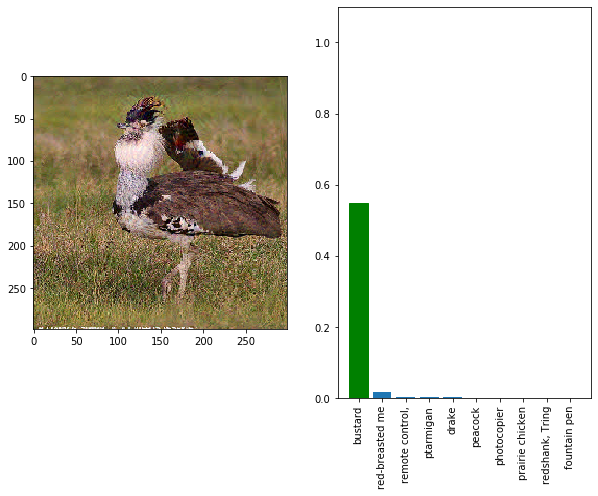

In [15]:
# the adversarial cannot bypass RDDfense (RDG + FD) method
classify(defend_GD(defend_FD_sig(newadv)),correct_class=cleanlabel[sampleindex],target_class=TARGET)

# Using a weak sample to demonstrate the defense

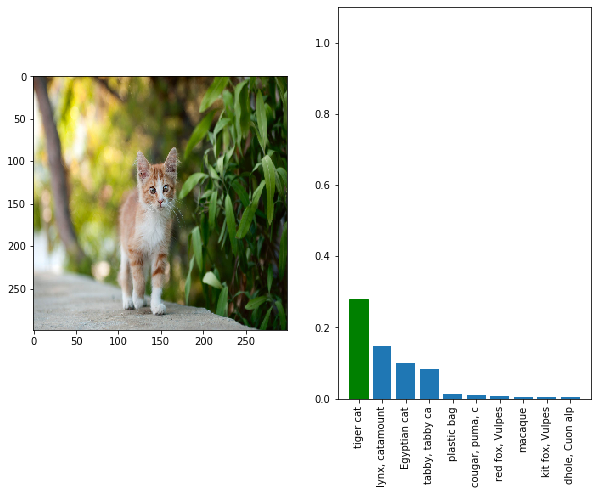

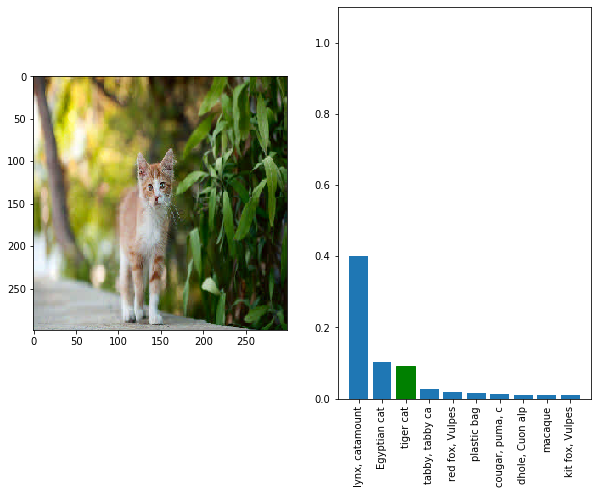

In [17]:
# demo based on a weak sample
# plot the original img and the defended version
classify(orig,correct_class=CORRECT_ori,target_class=TARGET_ori)
classify(defend_GD(defend_FD_sig(orig),0.25),correct_class=CORRECT_ori,target_class=TARGET_ori)

In [18]:
#将防御机制导入进session以进行变换和求解
x_single = tf.placeholder(tf.float32, (299, 299, 3))
TARGET = TARGET_ori

In [19]:
ENSEMBLE_SIZE = 30# larger sample size -> better gradient estimate

In [20]:
ensemble_xs = tf.stack([tftensorGD(x_single) for _ in range(ENSEMBLE_SIZE)], axis=0)

ensemble_logits, ensemble_preds = inceptionv3.model(sess, ensemble_xs)
ensemble_labels = tf.tile(tf.expand_dims(tf.one_hot(TARGET, 1000), axis=0), (ensemble_logits.shape[0], 1))
ensemble_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=ensemble_logits, labels=ensemble_labels))
ensemble_grad, = tf.gradients(ensemble_loss, x_single)
ensemble_probs = tf.nn.softmax(ensemble_logits)

INFO:tensorflow:Scale of 0 disables regularizer.


In [21]:
# BPDA + EOT
LR = 0.1

newadv = np.copy(orig)

for i in range(50):
    gradadv = defend_FD_sig(newadv)
    g, p, probs= sess.run([ensemble_grad, ensemble_preds,ensemble_probs], {x_single: gradadv})
    counts = np.bincount(p)
    p_label = np.argmax(counts)
    if i % 5 == 0:
        print('step %d, preds=%s' % (i, p_label))
    if p_label == TARGET:
        print('takes %d steps to conquer' % (i))
        break
    newadv -= LR * g
    # project
    newadv = np.clip(newadv, 0, 1)

step 0, preds=287
step 5, preds=287
step 10, preds=287
step 15, preds=287
step 20, preds=287
step 25, preds=287
step 30, preds=287
step 35, preds=287
step 40, preds=287
step 45, preds=287


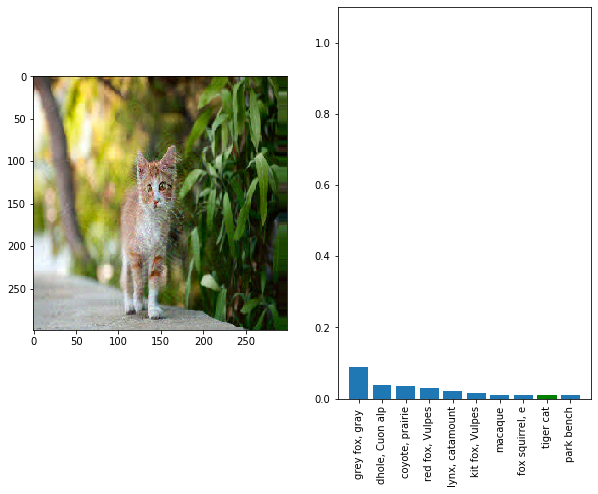

In [20]:
classify(defend_GD(defend_FD_sig(newadv)),correct_class=CORRECT_ori,target_class=TARGET_ori)